In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from skimage.segmentation import slic, mark_boundaries
from joblib import Parallel, delayed
import pandas as pd
%matplotlib inline

In [35]:
path = 'Leaf_disease'

In [36]:
for folders, _, files in os.walk(path):
    print(folders)

Leaf_disease
Leaf_disease\Bacterial leaf blight
Leaf_disease\Bacterial Leaf blight masks
Leaf_disease\Bacterial_leaf_blight_seg
Leaf_disease\Brown spot
Leaf_disease\Brown spot masks
Leaf_disease\Brown_spot_seg
Leaf_disease\Leaf smut
Leaf_disease\leaf smut masks
Leaf_disease\Leaf_smut_seg


In [37]:
for folders in os.listdir(path):
    print(folders)

Bacterial leaf blight
Bacterial Leaf blight masks
Bacterial_leaf_blight_seg
Brown spot
Brown spot masks
Brown_spot_seg
Leaf smut
leaf smut masks
Leaf_smut_seg
.gitignore


In [38]:
image = cv2.imread(path + '\\Brown spot\\DSC_0101.jpg')
mask = cv2.imread(path + '\\Brown spot masks\\DSC_0101.pgm', 0)

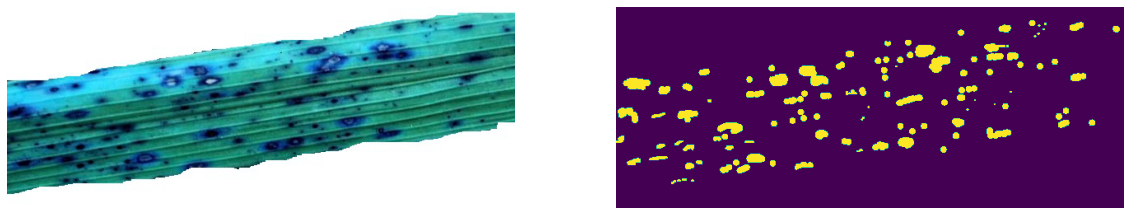

In [39]:
fig, axs = plt.subplots(1,2)

fig.set_figheight(20)
fig.set_figwidth(20)

axs[0].imshow(image)
axs[0].set_axis_off()
axs[1].imshow(mask)
axs[1].set_axis_off()

plt.show()

In [40]:
slic_image = slic(image, 100)

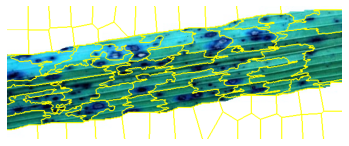

<Figure size 2160x2160 with 0 Axes>

In [41]:
plt.imshow(mark_boundaries(image, slic_image))
plt.axis('off')
plt.figure(figsize=(30, 30))
plt.show()

In [42]:
boundary_seg_image = mark_boundaries(image, slic_image, color=(1,0,0))

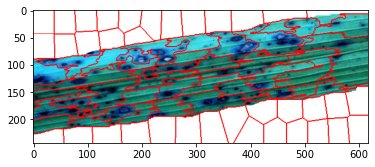

In [43]:
plt.imshow(boundary_seg_image)

In [44]:
boundary_seg_image[0].shape

(617, 3)

In [45]:
boundary_seg_image.shape

(244, 617, 3)

In [46]:
boundary_seg_image[1].shape

(617, 3)

In [47]:
slic_image[0].shape

(617,)

In [48]:
slic_image[1].shape

(617,)

In [49]:
slic_image.shape

(244, 617)

In [50]:
len(slic_image)

244

In [51]:
mask.shape

(244, 617)

In [52]:
np.unique(mask)

array([  0, 255], dtype=uint8)

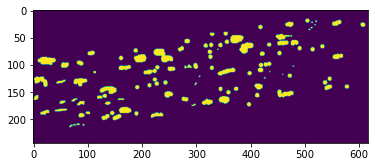

In [53]:
plt.imshow(mask)

In [54]:
%%time
c = 0
for x in tqdm(range(slic_image.shape[0]), total=slic_image.shape[0]):
    for y in range(slic_image.shape[1]):
        if slic_image[x, y] == 1:
            c += 1
        
    

100%|██████████| 244/244 [00:00<00:00, 3595.95it/s]


Wall time: 69.8 ms


In [55]:
masks = []
for i, segVal in enumerate(np.unique(slic_image)):
    mask = np.zeros(slic_image.shape[:2], dtype="uint8")
        
    mask[slic_image.reshape(slic_image.shape[:2]) == segVal] = 255
    masks.append(mask)
    

In [56]:
np.where(mask == 255)

(array([218, 218, 218, ..., 243, 243, 243], dtype=int64),
 array([39, 40, 41, ..., 54, 55, 56], dtype=int64))

In [57]:
np.unique(mask)

array([  0, 255], dtype=uint8)

In [58]:
x_white = np.where(mask == 255)[0]
y_white = np.where(mask == 255)[1]

In [59]:
x_white

array([218, 218, 218, ..., 243, 243, 243], dtype=int64)

In [60]:
y_white

array([39, 40, 41, ..., 54, 55, 56], dtype=int64)

In [61]:
slic_image

array([[ 0,  0,  0, ..., 11, 11, 11],
       [ 0,  0,  0, ..., 11, 11, 11],
       [ 0,  0,  0, ..., 11, 11, 11],
       ...,
       [71, 71, 71, ..., 61, 61, 61],
       [71, 71, 71, ..., 61, 61, 61],
       [71, 71, 71, ..., 61, 61, 61]], dtype=int64)

2481 2481
[0 1]


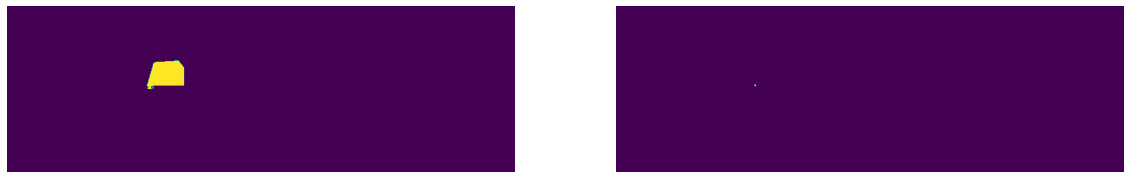

In [62]:
import numpy as np
import glob
from handle_imbalance import Imbalance
from sklearn import linear_model
superpixel_names = sorted(glob.glob('Labels\\RGB_superpixels\\*_multiclass.npy'))
masks = sorted(glob.glob('Labels\\mask_ground_truth\\*.npy'))

print(len(superpixel_names), len(masks))
        # for image_path, label_path in zip(superpixel_names, masks):
        #     image = np.load(image_path)
        #     label = np.load(label_path)
        #     print(np.unique(label))
        #
        #
        #     cv2.imshow('image', image)
        #     cv2.imshow('label', label)
        #     cv2.waitKey(100)
            image = np.load(superpixel_names[0])
            X_train = np.load(superpixel_names[0])[:, :, 0]
            y_train = np.load(masks[0]).flatten()

            X_train_resampled, y_train_resampled = Imbalance()('random_under_sampler',
                                                                       X_train.reshape(-1, 1),
                                                                       y_train)

            model = linear_model.LogisticRegression().fit(
                        X_train_resampled, y_train_resampled
                    )

            pred = model.predict(np.load(superpixel_names[1])[:, :, 0].reshape(-1, 1))
            print(np.unique(pred))
            pred = pred.reshape((image.shape[0], image.shape[1]))

            fig, axs = plt.subplots(1,2)

            fig.set_figheight(20)
            fig.set_figwidth(20)

            axs[0].imshow(pred)
            axs[0].set_axis_off()
            axs[1].imshow(np.load(masks[0]))
            axs[1].set_axis_off()

            plt.show()

In [65]:
labels = [np.load(mask).flatten() for mask in tqdm(masks[:2000], total=len(masks[:2000]))]
np.save('Labels/mask_ground_truth/labels.npy', labels)
print(np.asarray(labels).flatten())

100%|██████████| 2000/2000 [01:06<00:00, 30.18it/s]


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8) ...
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)]


In [68]:
labels = np.load('Labels/mask_ground_truth/labels.npy', allow_pickle=True)
print(labels)


[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8) ...
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)]
